### **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### **Load Dataset**

In [2]:
df = pd.read_parquet("/workspaces/SentinelNet/data/DoS-Wednesday-no-metadata.parquet")

print("Dataset Shape:", df.shape)

print("\nDataset Head: \n")
print(df.head())

print("\nDataset info:\n")
print(df.info())

Dataset Shape: (584991, 78)

Dataset Head: 

   Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0         6          38308                  1                       1   
1         6            479                 11                       5   
2         6           1095                 10                       6   
3         6          15206                 17                      12   
4         6           1092                  9                       6   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                         6                         6                      6   
1                       172                       326                     79   
2                      3150                      3150                   1575   
3                      3452                      6660                   1313   
4                      3150                      3152                   1575   

   Fwd Packet Length Min  Fwd Packe

### **Data Cleaning**

In [3]:
# Check NaN and inf
print("NaN values:\n", df.isna().sum().sum())
print("Infinite values:\n", np.isinf(df.select_dtypes(include=[float, int])).sum().sum())

# Replace inf/-inf with NaN (if any)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop or fill missing values if present
df.dropna(inplace=True)

# Count and remove duplicates
print("Duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

NaN values:
 0
Infinite values:
 0


Duplicate rows: 0


### **Verify Label Column Integrity**

In [4]:
print(df['Label'].value_counts())

df['Label'] = df['Label'].replace({
    'DoS Hulk': 'Attack',
    'DoS GoldenEye': 'Attack',
    'DoS Slowhttptest': 'Attack',
    'DoS slowloris': 'Attack',
    'Heartbleed' : 'Attack',
    'BENIGN': 'Benign'
})

# Encode labels numerically
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

print("Final shape:", df.shape)
print("Classes:", le.classes_)


Label
Benign              391235
DoS Hulk            172846
DoS GoldenEye        10286
DoS slowloris         5385
DoS Slowhttptest      5228
Heartbleed              11
Name: count, dtype: int64
Final shape: (584991, 78)
Classes: ['Attack' 'Benign']


/tmp/ipykernel_49574/3871018720.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['Label'] = df['Label'].replace({


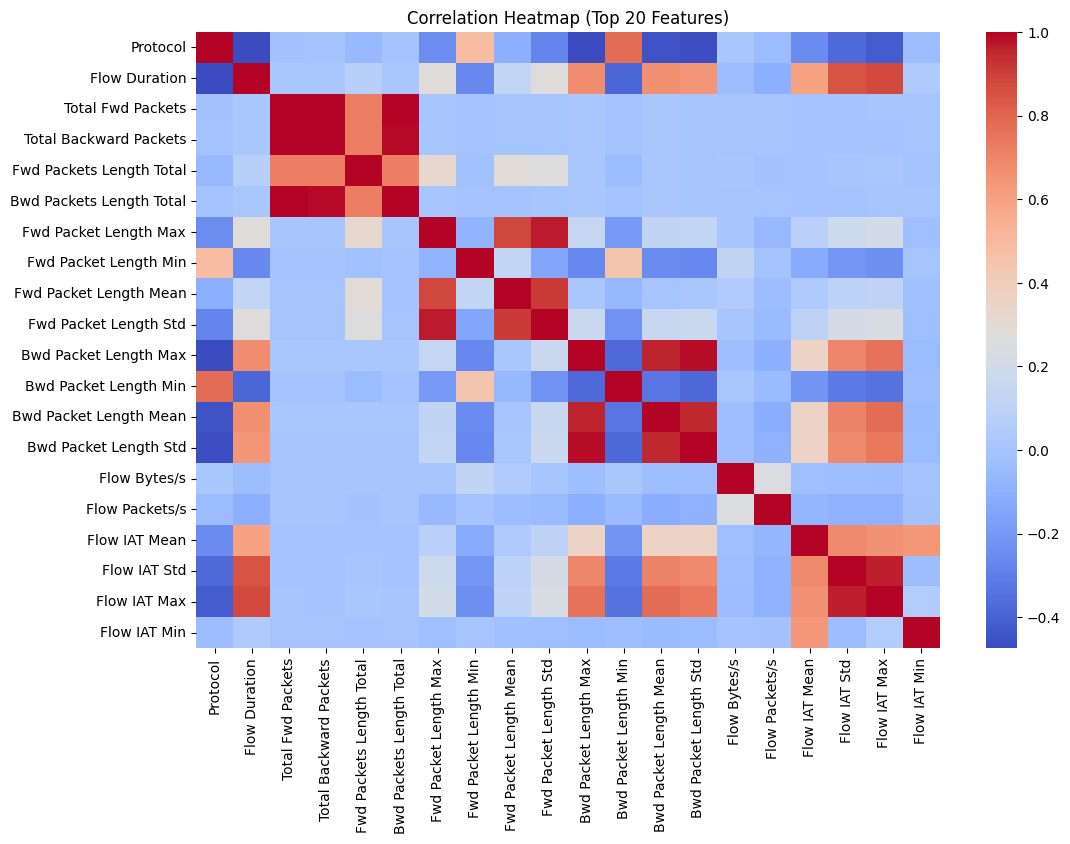

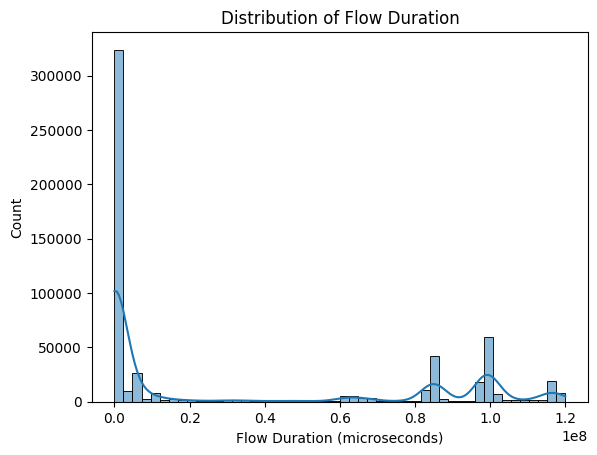

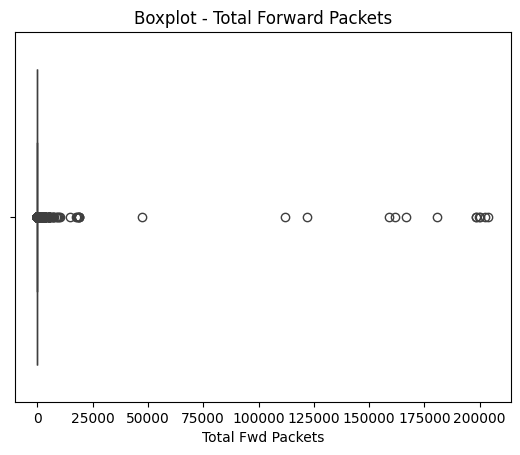

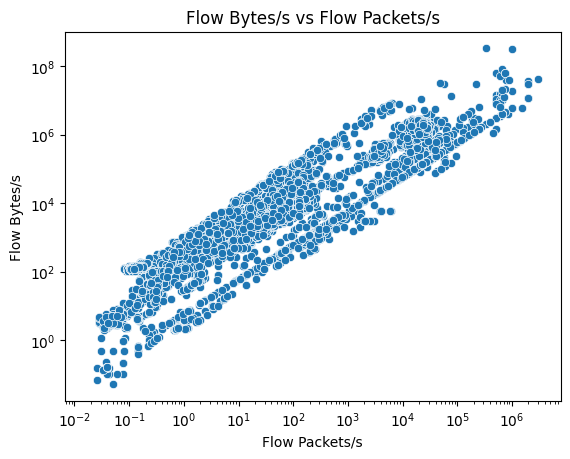

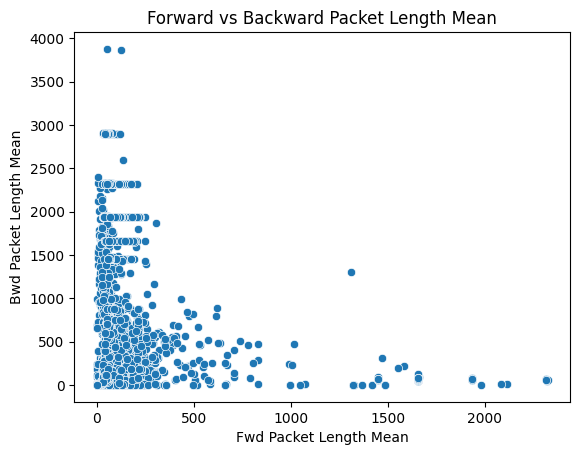

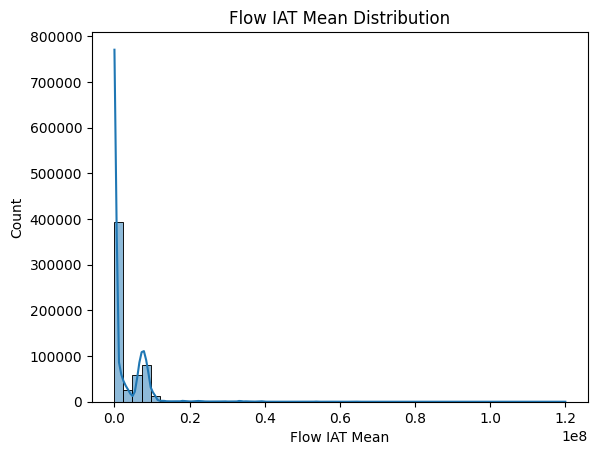

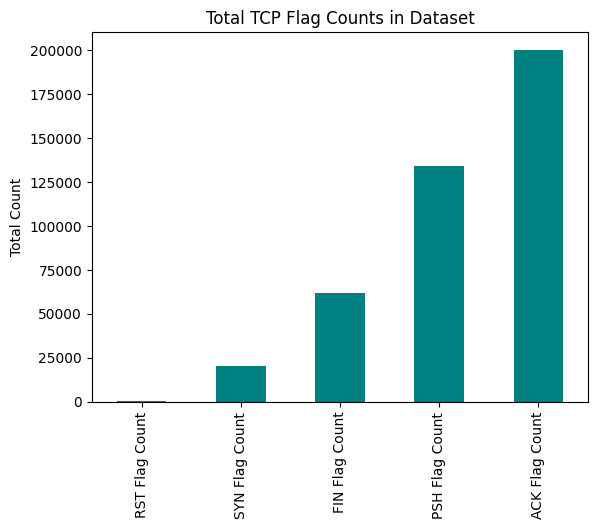

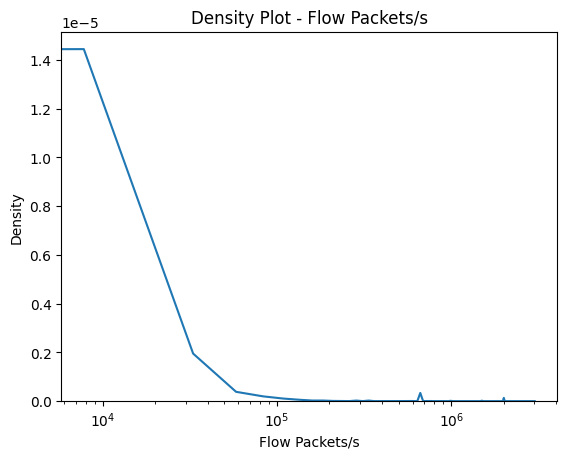

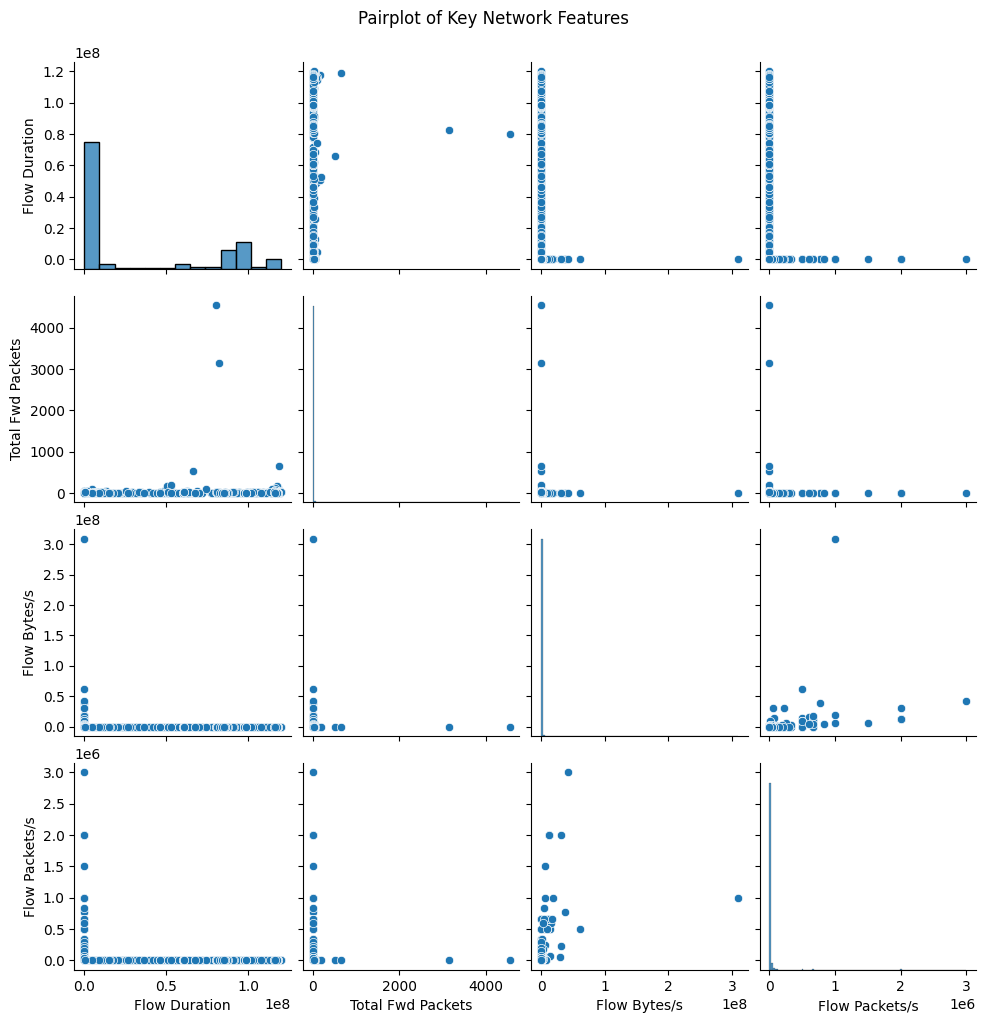

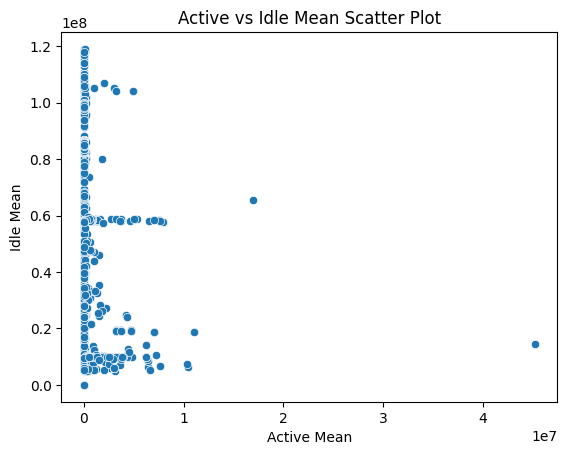

In [5]:
df_features = df

# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df_features.corr(numeric_only=True)
sns.heatmap(corr.iloc[:20, :20], cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Top 20 Features)")
plt.show()

# Distribution of Flow Duration
sns.histplot(df_features['Flow Duration'], bins=50, kde=True)
plt.title("Distribution of Flow Duration")
plt.xlabel("Flow Duration (microseconds)")
plt.show()

# Boxplot - Total Forward Packets
sns.boxplot(x=df_features['Total Fwd Packets'])
plt.title("Boxplot - Total Forward Packets")
plt.show()

# -Scatter Plot - Flow Bytes/s vs Flow Packets/s 
sample1 = df_features.sample(10000, random_state=42)
sns.scatterplot(x='Flow Packets/s', y='Flow Bytes/s', data=sample1)
plt.title("Flow Bytes/s vs Flow Packets/s")
plt.xscale('log')
plt.yscale('log')
plt.show()

# Scatter Plot - Fwd vs Bwd Packet Length Mean
sns.scatterplot(x='Fwd Packet Length Mean', y='Bwd Packet Length Mean', data=sample1)
plt.title("Forward vs Backward Packet Length Mean")
plt.show()

# Flow IAT Mean Distribution 
sns.histplot(df_features['Flow IAT Mean'], bins=50, kde=True)
plt.title("Flow IAT Mean Distribution")
plt.show()

# TCP Flag Count Overview 
flag_cols = ['FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 
             'PSH Flag Count', 'ACK Flag Count']
df_flags = df_features[flag_cols]
df_flags.sum().sort_values().plot(kind='bar', color='teal')
plt.title("Total TCP Flag Counts in Dataset")
plt.ylabel("Total Count")
plt.show()

# KDE Plot - Flow Packets/s 
sns.kdeplot(df_features['Flow Packets/s'], bw_adjust=0.5)
plt.title("Density Plot - Flow Packets/s")
plt.xscale('log')
plt.show()

# Pairplot - Selected Features 
sample2 = df_features.sample(3000, random_state=42)
sns.pairplot(sample2[['Flow Duration', 'Total Fwd Packets', 'Flow Bytes/s', 'Flow Packets/s']])
plt.suptitle("Pairplot of Key Network Features", y=1.02)
plt.show()

# Active vs Idle Mean Scatter
sns.scatterplot(x='Active Mean', y='Idle Mean', data=sample1)
plt.title("Active vs Idle Mean Scatter Plot")
plt.show()

In [7]:
le_label = LabelEncoder()
df['Label'] = le_label.fit_transform(df['Label'])  # Benign=0, Attack=1

categorical_cols = ['Protocol']  # rename according to dataset
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

df['byte_ratio'] = df['Fwd Packets Length Total'] / (df['Bwd Packets Length Total'] + 1)

df['count_srv_ratio'] = df['Total Fwd Packets'] / (df['Subflow Fwd Packets'] + 1)

agg_features = df.groupby('Label')[['Flow Duration', 'Fwd Packets Length Total', 'Bwd Packets Length Total']].mean().reset_index()
print("✅ Aggregated Features by Attack Type:")
print(agg_features)

# Remove the Label column for EDA
df_features = df.drop(columns=['Label'])

✅ Aggregated Features by Attack Type:
   Label  Flow Duration  Fwd Packets Length Total  Bwd Packets Length Total
0      0   7.263690e+07                394.428493              10032.801730
1      1   1.359780e+07                777.746725              25119.744624
